In [1]:
import pandas as pd
import pathlib, requests, re
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
import calendar

In [2]:
pathMR = pathlib.Path('../data/raw/others/MORTRATE.xlsx')
assert pathMR.exists()

In [211]:
seriesFHFA = pd.read_excel(pathMR, sheet_name='FHFA', encoding='utf-8', skiprows=[0])
seriesFHFA.index = pd.to_datetime(seriesFHFA.apply(lambda x: str(int(x['Year'])) + '-' + str(int(x['Month'])) + '-1', axis=1))
seriesFHFA['month'] = seriesFHFA.index.to_period('M')
seriesFHFA = seriesFHFA.groupby('month').mean()
seriesFHFA = seriesFHFA['Effective Interest Rate (%)']

In [212]:
# seriesFreddieMac = pd.read_excel(pathMR, sheet_name='FreddieMac', encoding='utf-8', skiprows=[0])
# seriesFreddieMac.index = pd.to_datetime(seriesFreddieMac['Week'])
# seriesFreddieMac['month'] = seriesFreddieMac.index.to_period('M')
# seriesFreddieMac = seriesFreddieMac.groupby('month').mean()

In [213]:
seriesIndex = pd.read_excel(pathMR, sheet_name='Index', encoding='utf-8')
seriesIndex['IndexValue'] = seriesIndex['IndexValue'].map(lambda x: float(str(x).replace('\u200b', '')))
seriesIndex.index = pd.to_datetime(seriesIndex['ObservationDate'])
seriesIndex['month'] = seriesIndex.index.to_period('M')
seriesIndex.index = seriesIndex['month']

In [214]:
for index, row in seriesIndex.iterrows():
    if pd.isnull(row['VintageDate']):
        year = row['ObservationDate'].year
        month = row['ObservationDate'].month
        if month == 12:
            year += 1
            month = 1
        else:
            month += 1
        day = max([week[calendar.FRIDAY] for week in calendar.monthcalendar(year=year, month=month)])
        seriesIndex.loc[index, 'VintageDate'] = pd.to_datetime(f'{year}-{month:02}-{day:02}', format='%Y-%m-%d')

In [215]:
series = pd.merge(seriesFHFA, seriesFreddieMac, left_index=True, right_index=True, how='outer')
series = pd.merge(series, seriesIndex, left_index=True, right_index=True, how='outer')

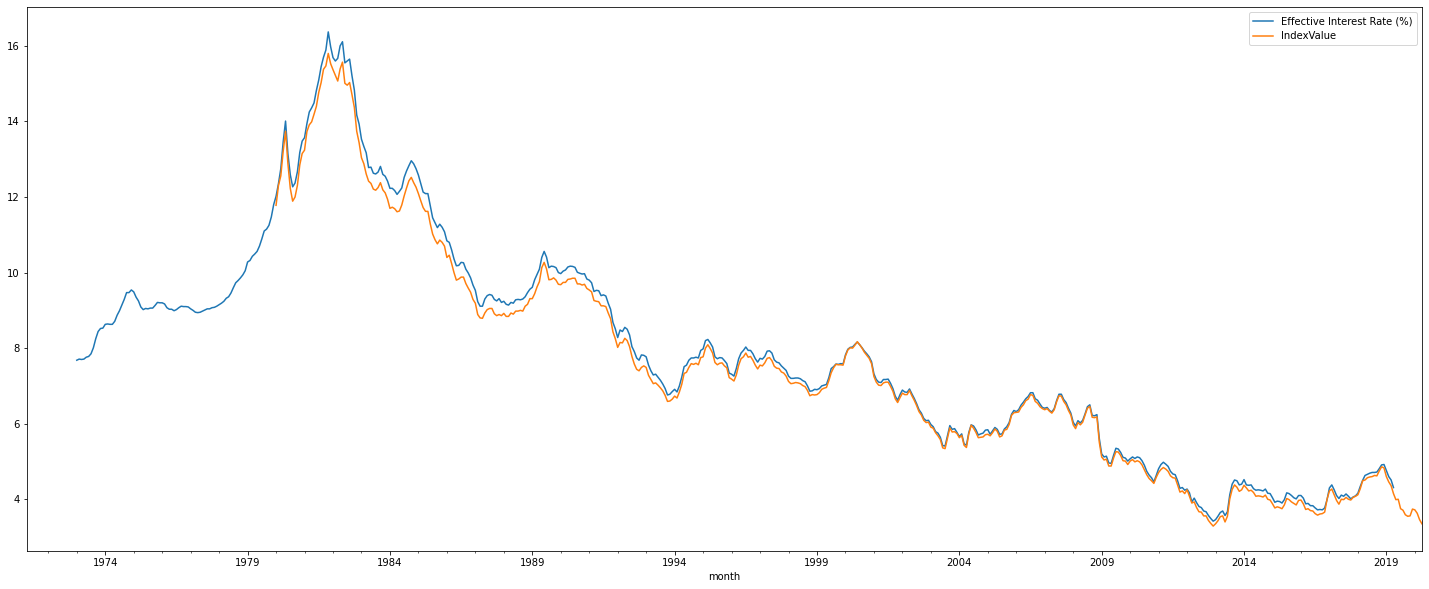

In [216]:
series[['Effective Interest Rate (%)', 'IndexValue']].plot(figsize= (25, 10))

In [217]:
y = series['Effective Interest Rate (%)'][-40:]
X = sm.add_constant(series['IndexValue'][-40:])
results = sm.OLS(y, X, missing='drop').fit()
print(results.summary())

OLS Regression Results                                
Dep. Variable:     Effective Interest Rate (%)   R-squared:                       0.978
Model:                                     OLS   Adj. R-squared:                  0.977
Method:                          Least Squares   F-statistic:                     1150.
Date:                         Wed, 03 Jun 2020   Prob (F-statistic):           4.72e-23
Time:                                 23:52:29   Log-Likelihood:                 47.788
No. Observations:                           28   AIC:                            -91.58
Df Residuals:                               26   BIC:                            -88.91
Df Model:                                    1                                         
Covariance Type:                     nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------

In [218]:
series['MORTRATE'] = float('nan')
for index, row in series.iterrows():
    if pd.isnull(row['Effective Interest Rate (%)']):
        series.loc[index, 'MORTRATE'] = row['IndexValue']
    else:
        series.loc[index, 'MORTRATE'] = row['Effective Interest Rate (%)']

In [225]:
series = series[['VintageDate', 'Effective Interest Rate (%)', 'IndexValue', 'MORTRATE']]
series.index = series.index.map(lambda x: x.strftime('%m/%d/%Y'))

In [20]:
series = pd.read_excel(pathMR, sheet_name='series', encoding='utf-8', index_col=0)
series.index = pd.to_datetime(series.index).to_period('M').start_time

In [13]:
pathMR2 = pathlib.Path('../data/raw/others/MORTRATE2.xlsx')
with pd.ExcelWriter(pathMR2) as writer:
    series.to_excel(writer, sheet_name='series')

In [21]:
series = pd.read_excel(pathMR, sheet_name='series', encoding='utf-8', index_col=0)

In [34]:
series['VintageDate'][1] > series['VintageDate'][90]

False

In [44]:
not pd.isnull(vintageDate)

False

In [45]:
df = pd.DataFrame(index = series.index)

for vintageDate in series['VintageDate']:
    if not pd.isnull(vintageDate):
        column = 'MORTRATE_'+vintageDate.strftime('%Y%m%d')
        df[column] = series['MORTRATE'].values
        for row in df.index:
            if series[series.index == row]['VintageDate'].values[0] > vintageDate:
                df.loc[row, column] = float('nan')

In [49]:
df.index = df.index.map(lambda x: x.strftime('%m/%d/%Y'))

In [50]:
pathMR2 = pathlib.Path('../data/raw/others/MORTRATE2.xlsx')
with pd.ExcelWriter(pathMR2) as writer:
    df.to_excel(writer, sheet_name='dataframe')